Bayes Rule Book:

https://www.bayesrulesbook.com/chapter-17.html

Materials from the Bayes Rule github:

https://github.com/bayes-rules/bayesrules

# Imports

In [1]:
import math, pyreadr
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from os.path import exists

import pyro
import torch as t
import pyro.distributions as dist
from pyro.infer import MCMC
from pyro.infer.mcmc.nuts import NUTS

# Hierarchical Models With Predictors

Runner dataset showing marathon times for multiple runners over consecutive years.

## Data

In [2]:
file_name = 'cherry_blossom_sample'
folder    = 'ch17'

data_url = f"https://github.com/bayes-rules/bayesrules/raw/master/data/{file_name}.rda"

if exists(f"/Users/zr/Geek/tutorials/bayesian_rules/{folder}/{file_name}.csv"):
    df = pd.read_csv(f"/Users/zr/Geek/tutorials/bayesian_rules/{folder}/{file_name}.csv")
    df = df.drop(columns=['Unnamed: 0'])
else:
    # pyreadr downloads remote file, saves locally and converts the RDA datafile to a pandas DataFrame
    file_path = f"/Users/zr/Geek/tutorials/bayesian_rules/{folder}/{file_name}.rda"
    pyreadr.download_file(data_url, file_path)
    result = pyreadr.read_r(file_path)
    df = result[file_name]
    df.to_csv(f"/Users/zr/Geek/tutorials/bayesian_rules/{folder}/{file_name}.csv")

In [5]:
df = df[['runner', 'age', 'net']].dropna()

In [6]:
df

runner  age         net
0        1   53   83.983333
1        1   54   74.300000
2        1   55   75.150000
3        1   56   74.216667
4        1   57   74.250000
..     ...  ...         ...
244     35   59   87.150000
246     36   53  105.750000
247     36   54  103.016667
248     36   56  105.416667
249     36   57  115.766667

[185 rows x 3 columns]

*...skipping pooled and non-pooled examples are going straight to the semi-pooled section...*

## Model

We start with:

- $Y_{ij}|\mu_j,\sigma_y \sim N(\mu_j, \sigma_y)~~$ *model of running times **within** runner $j$*
- $\mu_j|\mu,\sigma_{\mu} \sim N(\mu, \sigma_{\mu})~~~~~$ *model of variance **between** runners*
- $\mu,\sigma_y,\sigma_{\mu} \sim ...~~~~~~~~~~~~~~$ *our global priors*

Breaking down each layer individually:

### Layer 1: Variability of a specific runner

We want to incorporate our predictor, `age` into the mix. We can do this by setting our input mean param, $\mu_j = \beta_{0j}+\beta_1X_{ij}$

*NOTE: (per book) the subscript of our intercept term, $\beta_{0j}$ means it is local to the group $j$ while $\beta_1$ is shared amongst all groups. Effectively, this means we assume that the change in net time over age is consistent (though variability is group-dependent), each runner is just starting from a different point.* 

### Layer 2: Variability amongst runners

> It’s important to recognize here that our 36 sample runners are drawn from the same broader population of runners. Thus, instead of taking a no pooling approach, which assigns each $\beta_{0j}$ a unique prior, and hence assumes that one runner $j$ can’t tell us about another, these intercepts should share a prior. To this end we’ll assume that the runner-specific intercept parameters, and hence baseline running speeds, vary normally around some mean $\beta_0$ with standard deviation $\sigma_0$:

- $\beta_{0j}|\beta_0,\sigma_0 \sim N(\beta_0,\sigma_0)$

Here, $\beta_0$ and $\sigma_0$ are global priors

## Layer 3: Global Priors

Here is the list of priors we need to define:

|prior|description|
|:-|:-|
|$\beta_0$      | What we believe the average running time is across the sampled population|
|$\sigma_0$     | Our certainty about how the runners will conform to that mean|
|$\beta_1$      | Our initial guess at the effect of age on time|
|$\sigma_{y}$   | Our guess of the variability within a runner|

### Updated Model with predictor

- $Y_{ij}|\beta_{0j},\beta_1,\sigma_y \sim N(\mu_{ij}, \sigma_y)$ with $\mu_j = \beta_{0j}+\beta_1X_{ij}~~$ *regression of running times **within** runner $j$*
- $\beta_{0j}|\beta_0,\sigma_0 \sim N(\beta_0,\sigma_0)~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ *baseline variability **between** runners*
<br /><br />
- $\beta_0 \sim N(m_0, s_0)$
- $\beta_1 \sim N(m_1, s_1)~~~~~~~~~~~~~~$ *Global Priors*
- $\sigma_0 \sim Exp(l_0)$
- $\sigma_y \sim Exp(l_y)$

### Tuning the priors

In [141]:
df.net.mean()

89.94684684599999

In [76]:
b0_mean = df.net.mean() #89.95
b0_std  = df.net.std() #13.98

age_net_means  = df[['age', 'net']].groupby('age').mean()
age_net_slopes = np.array([(age_net_means.loc[i].values[0] - age_net_means.loc[i-1].values[0]) for i in age_net_means.index[1:]])
b1_mean = age_net_slopes.mean() #0.874
b1_std  = age_net_slopes.std() #4.25

# from book, just using weak priors for l0 and l1
ly = 0.072
l0 = 1.


In [145]:
b1_mean

0.8742424227272726

### Building the Model

In [96]:
runner_ids  = t.tensor(pd.to_numeric(df.runner).values - 1, dtype=t.long)
runner_ages = t.tensor(df.age.values, dtype=t.float)
runner_nets = t.tensor(df.net.values, dtype=t.float)

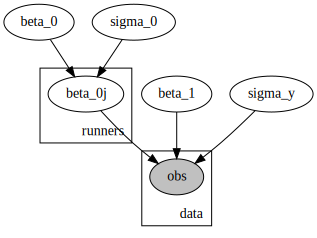

In [182]:
def model(runner_ids, ages, run_times=None):
    beta_0  = pyro.sample('beta_0', dist.Normal(b0_mean, b0_std))
    sigma_0 = pyro.sample('sigma_0', dist.Exponential(l0))

    with pyro.plate('runners', df.runner.nunique()):
        beta_0j = pyro.sample('beta_0j', dist.Normal(beta_0, sigma_0))

    beta_1    = pyro.sample('beta_1', dist.Normal(b1_mean, b1_std))
    sigma_y   = pyro.sample('sigma_y', dist.Exponential(ly))

    runner_mu = beta_0j[runner_ids] + beta_1*ages

    with pyro.plate('data', len(runner_ids)):
        return pyro.sample('obs', dist.Normal(runner_mu, sigma_y), obs=run_times)

pyro.render_model(model, model_args=(runner_ids, runner_ages, runner_nets))

In [147]:
pyro.clear_param_store
mcmc = MCMC(NUTS(model), 5000, warmup_steps=500)
mcmc.run(runner_ids, runner_ages, runner_nets)
mcmc.summary()

Sample: 100%|██████████| 5500/5500 [10:20,  8.86it/s, step size=4.85e-02, acc. prob=0.933]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta_0     68.99      8.97     69.18     54.80     83.61     49.02      1.00
 beta_0j[0]     54.76      9.43     54.86     39.98     70.43     49.54      1.00
 beta_0j[1]     62.36      9.26     62.55     47.72     77.80     49.94      1.00
 beta_0j[2]     68.23      9.10     68.39     54.13     83.12     48.72      1.00
 beta_0j[3]     80.12      9.40     80.28     65.13     95.58     49.59      1.00
 beta_0j[4]     55.12      9.17     55.26     40.15     70.01     48.41      1.00
 beta_0j[5]     54.55      9.93     54.80     38.00     70.02     49.87      1.00
 beta_0j[6]     79.61      9.08     79.73     65.86     94.92     49.38      1.00
 beta_0j[7]     81.31      9.48     81.45     65.44     96.25     49.95      1.00
 beta_0j[8]     77.09      9.74     77.27     62.18     93.48     49.45      1.00
 beta_0j[9]     93.61      9.51     93.83     77.90    108.30     49.16      1.00
beta_0j[10]    

In [389]:
samples = mcmc.get_samples()

beta_0j_samples = samples['beta_0j'][-50:,:].numpy()
beta_1_samples  = samples['beta_1'][-50:].numpy()
sigma_y_samples = samples['sigma_y'][-50:].numpy()

ages = np.tile(np.arange(df.age.min(), df.age.max()+1), 50).reshape((50,12))

# shape: (50, 36, 12) -> 50 samples, 36 runners, 12 ages
obs_samples = (beta_0j_samples.reshape((50, 36,1)) + np.tile((beta_1_samples[:,None] * ages),36).reshape((50,36,12)))

In [405]:
# By Runner (overall)
fig = ff.create_distplot(
    [obs_samples[:, runner_id-1, :].flatten() for runner_id in df.runner.unique().astype(int)], 
    [f'runner {id}' for id in df.runner.unique()], 
    show_rug=False
)
fig.update_layout(title_text='By Runner')
fig

In [411]:
# By Age
fig = ff.create_distplot(
    [obs_samples[:, :, i].flatten() for i in range(df.age.nunique())], 
    [f'age {age}' for age in df.age.unique()], 
    show_rug=False
)
fig.update_layout(title_text='By Age')
fig

In [413]:
dist_data = []
dist_labels = []
for id in df.runner.unique():
    dist_data.append(df.loc[df.runner==id, 'net'])
    dist_data.append(obs_samples[:,int(id)-1,:].flatten())
    dist_labels.extend([f'{id}_act',f'{id}_pred'])

dist_fig = ff.create_distplot(dist_data, dist_labels, show_rug=False)
dist_fig

In [414]:
fig = make_subplots(rows=df.runner.nunique()//2, cols=2, subplot_titles=[f'runner_{i}' for i in range(df.runner.nunique())], horizontal_spacing=.03, vertical_spacing=.015)

for i in range(0, df.runner.nunique()*2, 2):
    id = i//2
    fig.add_trace(go.Histogram(dist_fig['data'][i]),   row=(id//2)+1, col=(id%2)+1)
    fig.add_trace(go.Scatter(dist_fig['data'][i+72]),  row=(id//2)+1, col=(id%2)+1)

    fig.add_trace(go.Histogram(dist_fig['data'][i+1]), row=(id//2)+1, col=(id%2)+1)
    fig.add_trace(go.Scatter(dist_fig['data'][i+73]),  row=(id//2)+1, col=(id%2)+1)

fig.update_layout(height=22*300)
fig